## Predicting Survival on the Titanic

### History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

### Assignment:

Build a Machine Learning Pipeline, to engineer the features in the data set and predict who is more likely to Survive the catastrophe.

Follow the Jupyter notebook below, and complete the missing bits of code, to achieve each one of the pipeline steps.

In [33]:
import re

# to handle datasets
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# to build the models
from sklearn.linear_model import LogisticRegression

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score

# to persist the model and the scaler
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

## Prepare the data set

In [34]:
# load the data - it is available open source and online

data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')

# display data
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


In [35]:
# replace interrogation marks by NaN values

data = data.replace('?', np.nan)

In [36]:
# retain only the first cabin if more than
# 1 are available per passenger

def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data['cabin'] = data['cabin'].apply(get_first_cabin)

In [37]:
# extracts the title (Mr, Ms, etc) from the name variable

def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
data['title'] = data['name'].apply(get_title)

In [38]:
# cast numerical variables as floats

data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')

In [39]:
# drop unnecessary variables

data.drop(labels=['name','ticket', 'boat', 'body','home.dest'], axis=1, inplace=True)

# display data
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


In [40]:
# save the data set

data.to_csv('titanic.csv', index=False)

## Data Exploration

### Find numerical and categorical variables

In [41]:
target = 'survived'

In [42]:
data

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs
...,...,...,...,...,...,...,...,...,...,...
1304,3,0,female,14.5000,1,0,14.4542,NaN,C,Miss
1305,3,0,female,NaN,1,0,14.4542,NaN,C,Miss
1306,3,0,male,26.5000,0,0,7.2250,NaN,C,Mr
1307,3,0,male,27.0000,0,0,7.2250,NaN,C,Mr


In [43]:
vars_num = [var for var in data.columns if data[var].dtype != 'O' and var != target] 

vars_cat = [var for var in data.columns if data[var].dtype == 'O' and var != target] 

print('Number of numerical variables: {}'.format(len(vars_num)))
print('Number of categorical variables: {}'.format(len(vars_cat)))

Number of numerical variables: 5
Number of categorical variables: 4


### Find missing values in variables

In [44]:
# first in numerical variables
var_num_with_na = [var for var in vars_num if data[var].isnull().sum()>0]
data[var_num_with_na].isnull().mean()

age     0.200917
fare    0.000764
dtype: float64

In [45]:
# now in categorical variables

var_cat_with_na = [var for var in vars_cat if data[var].isnull().sum()>0]
data[var_cat_with_na].isnull().mean()

cabin       0.774637
embarked    0.001528
dtype: float64

### Determine cardinality of categorical variables

In [46]:
data[vars_cat].nunique()

sex           2
cabin       181
embarked      3
title         5
dtype: int64

### Determine the distribution of numerical variables

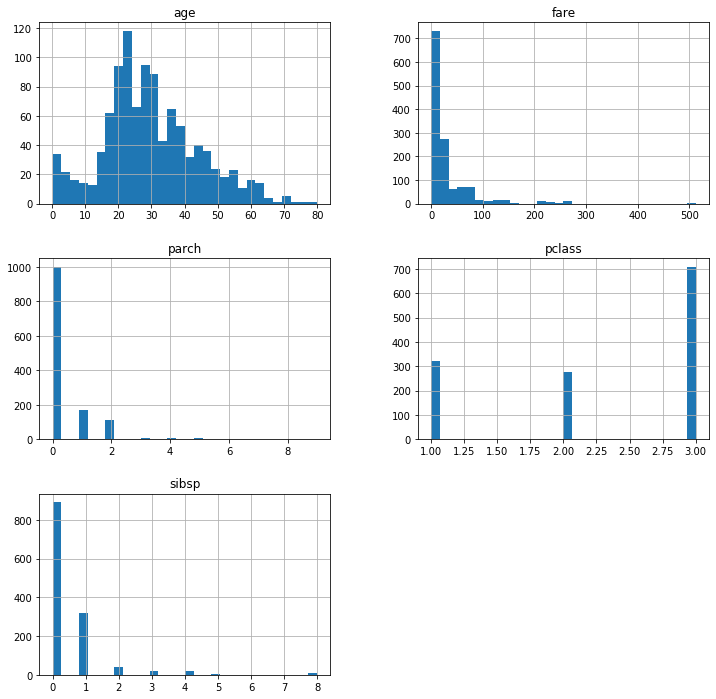

In [47]:
data[vars_num].hist(bins=30,figsize = (12,12))
plt.show()

## Separate data into train and test

Use the code below for reproducibility. Don't change it.

In [86]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1047, 9), (262, 9))

## Feature Engineering

### Extract only the letter (and drop the number) from the variable Cabin

In [87]:
X_train['cabin'] = X_train['cabin'].str[0]

In [88]:
X_test['cabin'] = X_test['cabin'].str[0]

### Fill in Missing data in numerical variables:

- Add a binary missing indicator
- Fill NA in original variable with the median

In [89]:
def fill_na(trainset,testset,column):
    median = trainset[column].median()
    trainset[column+'_NA'] = np.where(trainset[column].isnull,1,0)
    testset[column+'_NA'] = np.where(testset[column].isnull,1,0)
    trainset[column].fillna(value=median,inplace = True)
    testset[column].fillna(value=median,inplace = True)
    
    
    

In [90]:
for column in var_num_with_na:
    fill_na(X_train,X_test,column)

In [91]:
#checking null in train set
len([var for var in var_num_with_na if X_train[var].isnull().sum()>0] )



0

In [92]:
#checking null in train set
len([var for var in var_num_with_na if X_test[var].isnull().sum()>0] )

0

In [93]:
X_train.columns

Index(['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'cabin', 'embarked',
       'title', 'age_NA', 'fare_NA'],
      dtype='object')

### Replace Missing data in categorical variables with the string **Missing**

In [94]:
def fill_na_cat(trainset,testset,column):
    
    trainset[column].fillna(value='Missing',inplace = True)
    testset[column].fillna(value='Missing',inplace = True)
 
    

In [95]:
for column in var_cat_with_na:
    fill_na_cat(X_train,X_test,column)

In [96]:
len([var for var in var_cat_with_na if X_train[var].isnull().sum()>0] )

0

### Remove rare labels in categorical variables

- remove labels present in less than 5 % of the passengers

In [98]:
for var in vars_cat:
    print(X_train[var].value_counts()/len(X_train[var]))

male      0.633238
female    0.366762
Name: sex, dtype: float64
Missing    0.766953
C          0.074499
B          0.049666
E          0.034384
D          0.034384
A          0.018147
F          0.017192
G          0.003820
T          0.000955
Name: cabin, dtype: float64
S          0.709647
C          0.195798
Q          0.092646
Missing    0.001910
Name: embarked, dtype: float64
Mr        0.569245
Miss      0.200573
Mrs       0.159503
Master    0.044890
Other     0.025788
Name: title, dtype: float64


In [99]:
def find_frequent_labels(df,var,rare_perc):
    df = df.copy()
    tmp = df[var].value_counts()/len(df[var])
    return tmp[tmp > rare_perc].index

In [100]:
print(find_frequent_labels(X_train,'cabin',0.05))

Index(['Missing', 'C'], dtype='object')


In [101]:
#X_train['cabin'].isin((find_frequent_labels(X_train,'cabin',0.05)))
X_train['cabin'].isin(['Missing'])

1118     True
44      False
1072     True
1130     True
574      True
        ...  
763      True
835      True
1216     True
559      True
684      True
Name: cabin, Length: 1047, dtype: bool

In [102]:
for var in vars_cat:
    fr_lb = find_frequent_labels(X_train,var,0.05)
    X_train[var] = np.where(X_train[var].isin(fr_lb),X_train[var],'Rare')
    X_test[var]= np.where(X_test[var].isin(fr_lb),X_test[var],'Rare')

In [103]:
X_train['cabin'].value_counts()

Missing    803
Rare       166
C           78
Name: cabin, dtype: int64

In [104]:
X_train[vars_cat].nunique()

sex         2
cabin       3
embarked    4
title       4
dtype: int64

In [105]:
X_test[vars_cat].nunique()

sex         2
cabin       3
embarked    3
title       4
dtype: int64

### Perform one hot encoding of categorical variables into k-1 binary variables

- k-1, means that if the variable contains 9 different categories, we create 8 different binary variables
- Remember to drop the original categorical variable (the one with the strings) after the encoding

In [106]:
X_train = pd.get_dummies(X_train,columns = vars_cat,drop_first = True)

In [107]:
X_train.columns

Index(['pclass', 'age', 'sibsp', 'parch', 'fare', 'age_NA', 'fare_NA',
       'sex_male', 'cabin_Missing', 'cabin_Rare', 'embarked_Q',
       'embarked_Rare', 'embarked_S', 'title_Mr', 'title_Mrs', 'title_Rare'],
      dtype='object')

In [108]:
X_train.embarked_Rare.value_counts()

0    1045
1       2
Name: embarked_Rare, dtype: int64

In [109]:
X_test = pd.get_dummies(X_test,columns = vars_cat,drop_first = True)

In [110]:
X_test.columns

Index(['pclass', 'age', 'sibsp', 'parch', 'fare', 'age_NA', 'fare_NA',
       'sex_male', 'cabin_Missing', 'cabin_Rare', 'embarked_Q', 'embarked_S',
       'title_Mr', 'title_Mrs', 'title_Rare'],
      dtype='object')

In [111]:
X_test['embarked_Rare'] = 0

In [71]:
len(X_test.columns)==len(X_train.columns)

True

In [112]:
X_train.shape, X_test.shape

((1047, 16), (262, 16))

### Scale the variables

- Use the standard scaler from Scikit-learn

In [113]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [114]:

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Train the Logistic Regression model

- Set the regularization parameter to 0.0005
- Set the seed to 0

In [115]:
logreg = LogisticRegression(random_state=0,C=0.0005)

In [116]:
logreg.fit(X_train,y_train)

LogisticRegression(C=0.0005, random_state=0)

## Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

In [122]:
y_predict = logreg.predict(X_train)
y_probas = logreg.predict_proba(X_train)
train_accuracy_score=accuracy_score(y_train,y_predict)
train_roc_auc_score=roc_auc_score(y_train,y_probas[:,1])

print('Train set accuracy: ',train_accuracy_score)
print('Train set AUC-ROC: ',train_roc_auc_score)

#test set
y_predict = logreg.predict(X_test)
y_probas = logreg.predict_proba(X_test)
test_accuracy_score=accuracy_score(y_test,y_predict)
test_roc_auc_score=roc_auc_score(y_test,y_probas[:,1])

print('Test set accuracy: ',test_accuracy_score)
print('Test set AUC-ROC: ',test_roc_auc_score)

Train set accuracy:  0.7153772683858644
Train set AUC-ROC:  0.8414741112828439
Test set accuracy:  0.6717557251908397
Test set AUC-ROC:  0.7530555555555555


That's it! Well done

**Keep this code safe, as we will use this notebook later on, to build production code, in our next assignement!!**